In [1]:
import numpy as np 
import scanpy as sc
from spectra import spectra as spc
import seaborn as sns

In [2]:
import pandas as pd
import scipy 
import matplotlib.pyplot as plt

In [3]:
#matplotlib styles

import warnings
import matplotlib
%matplotlib inline
sns.set_style('white')
sns.set_style("ticks", {"xtick.direction": 'in', "ytick.direction": 'in'})

matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")

# Expanding a set of DC markers in CD34+ Bone Marrow cells

- Here we illustrate an example of a simple use case of spectra. We have a set of 5 genes important for late cDC development and want to expand them to a more complete set of early cDC development markers
- These are **LYZ**, **IFI30**, **ENTPD1**,**LY86**,and **ITGAX**, which coordinate a cDC1 fate decision

## Load AnnData Object

In [4]:
adata_rna = sc.read_h5ad("cd34_multiome_rna_no_bcells.h5ad")
#adata_atac = sc.read_h5ad("cd34_multiome_atac_no_bcells.h5ad")

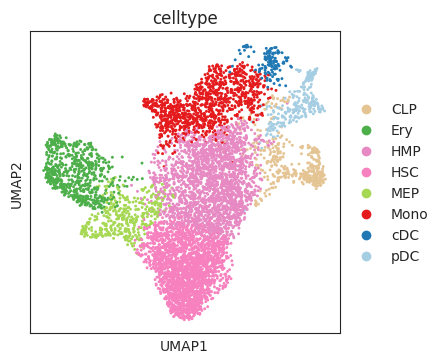

In [5]:
sc.pl.umap(adata_rna, color = ["celltype"], use_raw = False)

In [6]:
sc.pp.highly_variable_genes(adata_rna, n_top_genes = 1000)

## Visualize cDC lineage factors


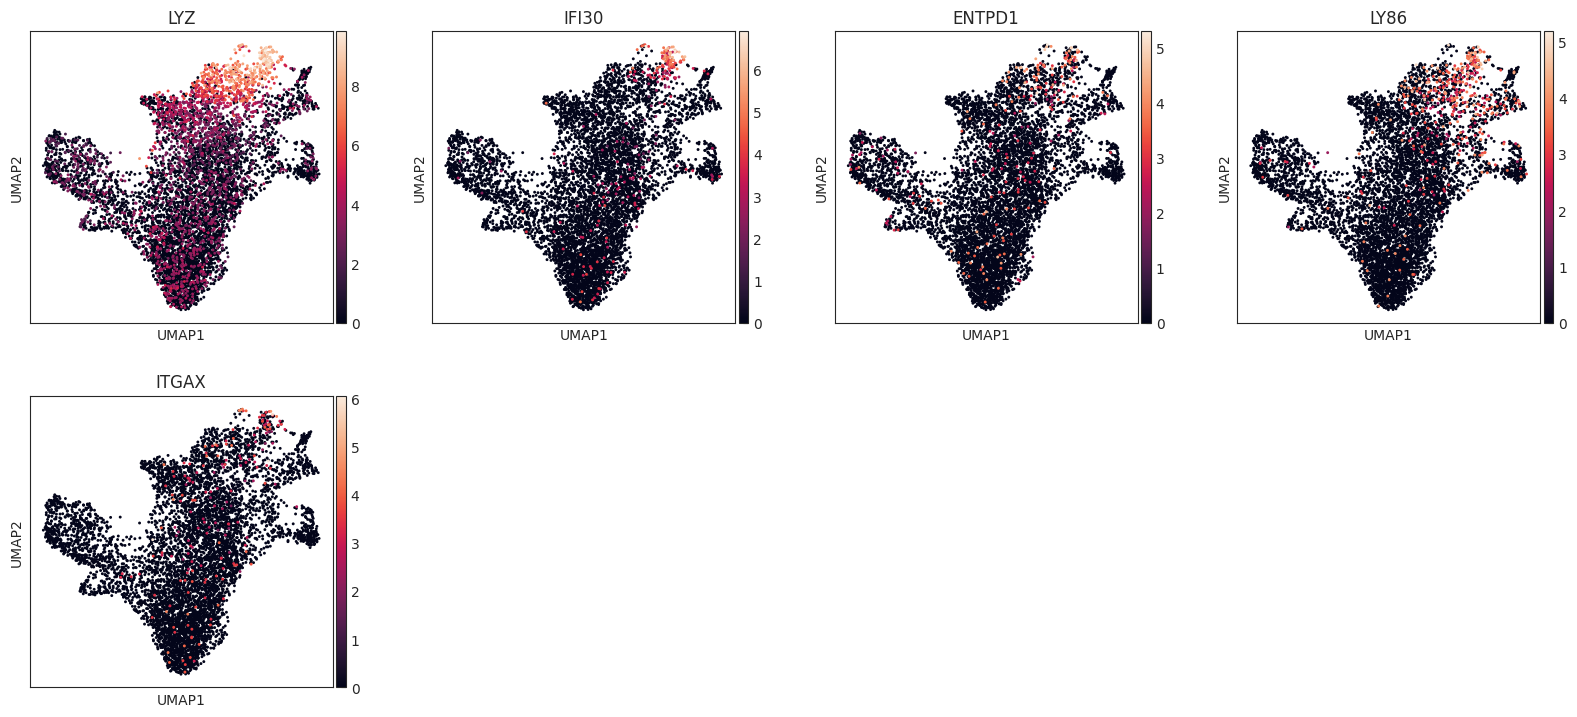

In [83]:
sc.pl.umap(adata_rna, color = ["LYZ", "IFI30", "ENTPD1","LY86","ITGAX"], use_raw = False)

## Filter to highly variable genes

- to have this run more quickly we will subset to the top 1000 highly variable genes

In [84]:
dc_set = ["LYZ", "IFI30", "ENTPD1","LY86","ITGAX"]
bools = np.array([True if x in dc_set else False for x in adata_rna.var_names])
adata2 = adata_rna[:,adata_rna.var.highly_variable|bools]

## Initialize number of factors and create adjacency matrix
- we will fit 10 latent factors, and create a binary matrix A that has the gene set information.

- In the matrix A, we store binary indicators of gene-gene interactions : in this case there are 6 interactions for the 3 genes. We do this by looping through the gene set twice and adding these connections. 

In [85]:
K = 10
X = adata2.X.todense()
X = np.array(X)
A = np.zeros((X.shape[1], X.shape[1]))


#id2gene is a dictionary with indices as keys and genes as values, gene2id is the opposite
id2gene = dict((idx, v) for idx, v in enumerate(adata2.var_names))
gene2id = dict((v, idx) for idx, v in enumerate(adata2.var_names))

for g1 in dc_set:
    for g2 in dc_set:
        if g1 != g2:
            if g1 in adata2.var_names:
                if g2 in adata2.var_names:
                    A[gene2id[g1], gene2id[g2]] = 1.0
                    A[gene2id[g2],gene2id[g1]] = 1.0 

## Initialize model parameters and fit

- model.initialize is very important as it prevents unfavorable local optima of the loss landscape

In [132]:
model = spc.SPECTRA_EM(X = X, A=A, K = K, lam = 1, T= 15, kappa = 0, rho = 0.3, delta = 0.1)
gene_sets = [[gene2id[gene] for gene in dc_set]]
model.initialize(gene_sets, val = 25)

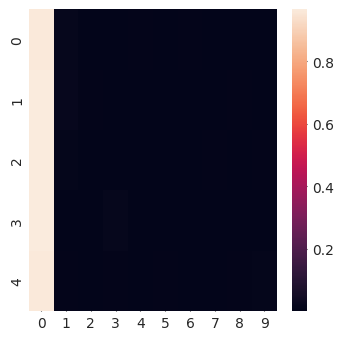

In [133]:
#check that initialization works
sns.heatmap(model.theta[np.argwhere(A.sum(axis = 1) > 0 ).ravel(), :])
plt.show()


In [145]:
model.fit(n_epochs = 25, suppress = True) #change n_epochs to 1000, running with 25 with suppres = True

/home/kunesr/miniconda3/envs/spectra_minimal2/lib/python3.7/site-packages/spectra/spectra.py:923: RuntimeWarning: divide by zero encountered in log
  log_term2 = contract('ij,ij,kl->ijkl',self.A, self.weights, np.log((1-self.kappa)*self.B + self.kappa))
/home/kunesr/miniconda3/envs/spectra_minimal2/lib/python3.7/site-packages/spectra/spectra.py:957: RuntimeWarning: invalid value encountered in true_divide
  inverse_hessian = -1.0*(self.theta**2)/(evidence + self.EPS)#analytic second derivative
/home/kunesr/miniconda3/envs/spectra_minimal2/lib/python3.7/site-packages/spectra/spectra.py:959: RuntimeWarning: invalid value encountered in true_divide
  gh = -1.0*(self.theta - (self.theta**2)/evidence*(self.g + self.delta).reshape(-1,1)*(self.alpha.sum(axis = 0).reshape(1,-1)))


## Examine markers per factor

In [147]:
df = model.markers( offset = .1, id2gene = id2gene, n_top = 15)

In [148]:
df

,factor0,factor1,factor2,factor3,factor4,factor5,factor6,factor7,factor8,factor9
0,LYZ,EBF1,AZU1,MECOM,ASPM,FAM160A1,PTPRD,ZNF385D,RPL13A,XACT
1,SLC8A1,DNTT,MPO,PREX2,UBE2C,UGCG,LINC01515,B2M,B2M,RYR3
2,SAMHD1,CD79A,ELANE,AVP,TOP2A,ALOX5AP,IL12RB2,RPL13A,RPS24,ACSM3
3,RBM47,VPREB1,EREG,HLF,MKI67,LIME1,CACNB2,MSI2,CD74,ITGA2B
4,GAS7,MYLK,FNDC3B,SKAP1,RRM2,CUX2,PPP1R9A,RPS24,BCL2,BLVRB
5,ANXA2,LTB,PRTN3,THRB,CENPE,LGMN,LNCAROD,MBNL1,ACTB,ANK1
6,CEBPD,BAALC,CTSG,IL12A-AS1,CENPF,IRF7,DOCK3,CD74,SDK2,HBD
7,IFI30,BAALC-AS1,LYST,LIMCH1,DIAPH3,CCDC50,PTPRM,NKAIN2,TMSB4X,APOC1
8,CCDC26,MME,CFD,RORA,LTBP1,ADAM19,MZB1,PRKG2,NEGR1,ZNF385D
9,WDR49,UBASH3B,PLPPR3,AREG,ARL6IP1,RNASE6,IFI6,PDZD2,MAP3K8,PTH2R


## Examine model loadings

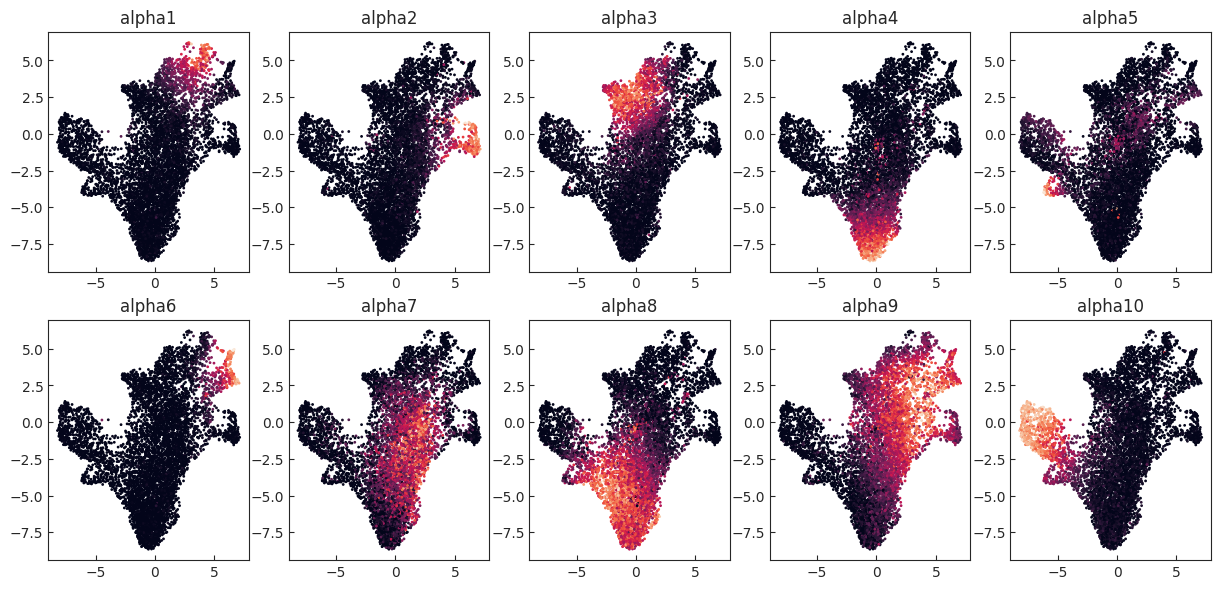

In [149]:
fig, axs = plt.subplots(2, 5, figsize=(15, 7))
ct = 0
for i in range(2):
    for j in range(5):
        axs[i, j].scatter(adata_rna.obsm["X_umap"][:,0], adata_rna.obsm["X_umap"][:,1], c = model.alpha[:,ct], s = 1)
        ct = ct + 1
        axs[i, j].set_title("alpha"+str(ct))
plt.show()

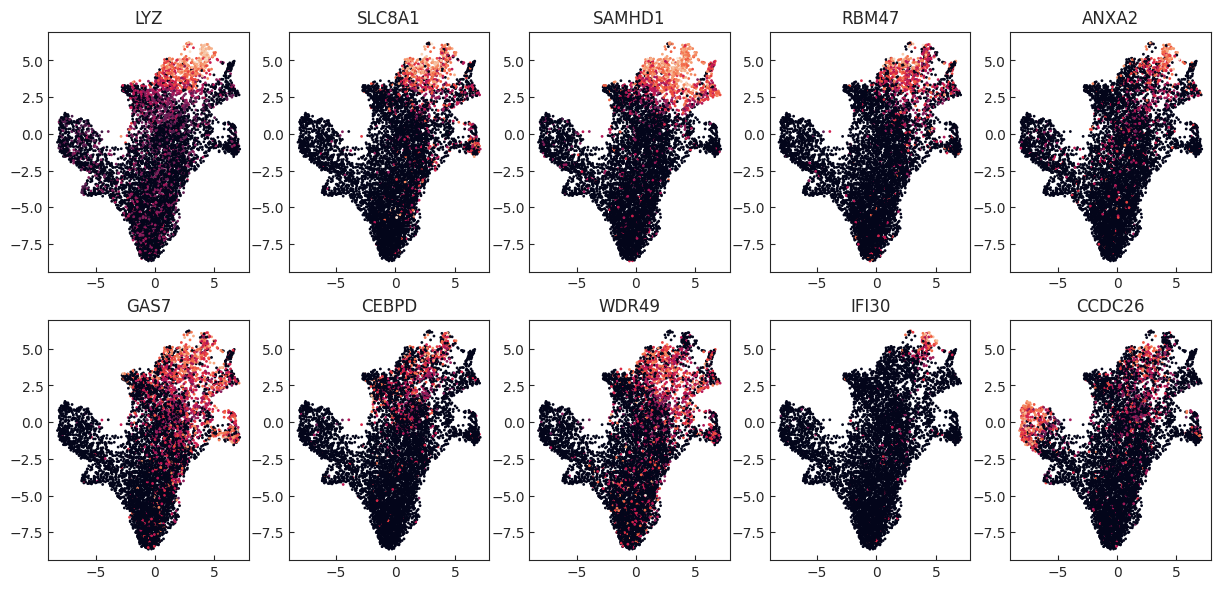

In [146]:
fig, axs = plt.subplots(2, 5, figsize=(15, 7))
ct = 0
for i in range(2):
    for j in range(5):
        gene = df["factor0"][ct]
        axs[i, j].scatter(adata_rna.obsm["X_umap"][:,0], adata_rna.obsm["X_umap"][:,1], c = np.array(adata_rna[:,gene].X.todense()), s= 1)
        ct = ct + 1
        axs[i, j].set_title(gene)
plt.show()

## Examine model.B

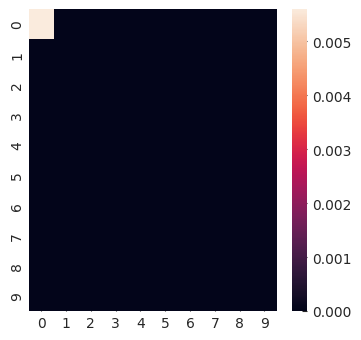

In [144]:
#plt.figure(figsize = (1,1))
sns.heatmap(model.B)
plt.show()

In [150]:
model.B.max()

0.005808710885208046